In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import time
def now():
    return time.strftime("%Y-%m-%d %H:%M:%S")


In [2]:
data = pd.read_csv("customer_churn_cleaned.csv")
print("Shape:", data.shape)
data.head()


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
data["Churn"] = data["Churn"].map({"Yes": 1, "No": 0})

# All object columns except target
cat_cols = data.select_dtypes(include="object").columns.tolist()
cat_cols.remove("customerID") if "customerID" in cat_cols else None

# One-hot encoding
data_encoded = pd.get_dummies(data.drop("customerID", axis=1), drop_first=True)
data_encoded.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,True,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,False,...,True,True,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [4]:
X = data_encoded.drop("Churn", axis=1)
y = data_encoded["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape



((5634, 23), (1409, 23))

In [6]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [7]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = y_pred

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_proba)
    }


In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dt = DecisionTreeClassifier(random_state=42)

dt_params = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

print("Running Decision Tree tuning at:", now())
dt_grid = GridSearchCV(dt, dt_params, cv=cv, scoring="roc_auc", n_jobs=-1)
dt_grid.fit(X_train, y_train)

dt_best = dt_grid.best_estimator_
print("Best DT Params:", dt_grid.best_params_)


Running Decision Tree tuning at: 2025-11-27 04:59:16
Best DT Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [10]:
rf = RandomForestClassifier(random_state=42)

rf_param_dist = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [None, 5, 7, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

print("Running Random Forest tuning at:", now())
rf_rand = RandomizedSearchCV(
    rf,
    param_distributions=rf_param_dist,
    n_iter=20,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_rand.fit(X_train, y_train)
rf_best = rf_rand.best_estimator_

print("Best RF Params:", rf_rand.best_params_)


Running Random Forest tuning at: 2025-11-27 05:03:36
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF Params: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 7}


In [13]:
from sklearn.impute import SimpleImputer

# 1) Create imputer and apply to train/test (median works for numeric features)
imp = SimpleImputer(strategy="median")

# fit on X_train and transform both
X_train = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test  = pd.DataFrame(imp.transform(X_test), columns=X_test.columns, index=X_test.index)

# 2) Now run the gradient boosting grid as before
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier(random_state=42)
gb_params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200],
    "max_depth": [2, 3, 4]
}

print("Running Gradient Boosting tuning at:", now())
gb_grid = GridSearchCV(gb, gb_params, cv=cv, scoring="roc_auc", n_jobs=-1)
gb_grid.fit(X_train, y_train)

gb_best = gb_grid.best_estimator_
print("Best GB Params:", gb_grid.best_params_)


Running Gradient Boosting tuning at: 2025-11-27 05:10:37
Best GB Params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}


In [14]:
results = []
results.append(evaluate_model("Decision Tree (tuned)", dt_best, X_test, y_test))
results.append(evaluate_model("Random Forest (tuned)", rf_best, X_test, y_test))
results.append(evaluate_model("Gradient Boosting (tuned)", gb_best, X_test, y_test))

results_df = pd.DataFrame(results).set_index("Model")
display(results_df)

results_df.to_csv("model_comparison_results.csv")


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Decision Tree (tuned),0.794180,0.629630,0.545455,0.584527,0.828358
Random Forest (tuned),0.803407,0.691700,0.467914,0.558214,0.846027
Gradient Boosting (tuned),0.797729,0.655052,0.502674,0.568835,0.845544


In [15]:
best_model_name = results_df["AUC"].idxmax()
print("Best Model:", best_model_name)

best_model = {
    "Decision Tree (tuned)": dt_best,
    "Random Forest (tuned)": rf_best,
    "Gradient Boosting (tuned)": gb_best
}[best_model_name]


Best Model: Random Forest (tuned)



Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1035
           1       0.69      0.47      0.56       374

    accuracy                           0.80      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



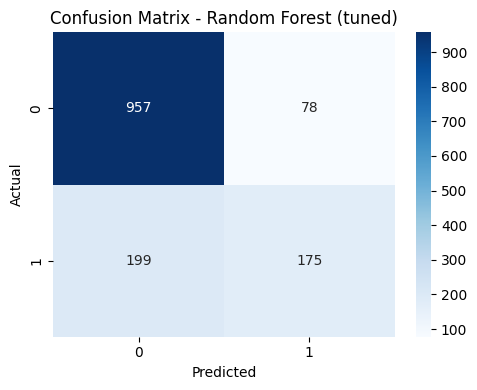

In [16]:
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_best))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("confusion_matrix_best_model.png", dpi=300)
plt.show()



Top 5 Features Influencing Churn:
 tenure                            0.204720
TotalCharges                      0.134495
InternetService_Fiber optic       0.118811
MonthlyCharges                    0.105738
PaymentMethod_Electronic check    0.089569
dtype: float64


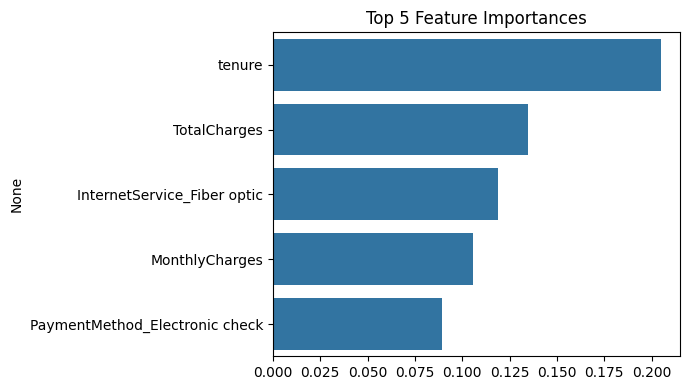

In [17]:
if hasattr(best_model, "feature_importances_"):

    importances = best_model.feature_importances_
    feature_names = X_train.columns

    feat_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top5 = feat_series.head(5)

    print("\nTop 5 Features Influencing Churn:\n", top5)

    plt.figure(figsize=(7,4))
    sns.barplot(x=top5.values, y=top5.index)
    plt.title("Top 5 Feature Importances")
    plt.tight_layout()
    plt.savefig("feature_importance_top5.png", dpi=300)
    plt.show()

else:
    print("Best model does not support feature importances.")
